<a href="https://colab.research.google.com/github/Zardian18/dog-vision/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# End-to-end multi-class dog breed classification

## 1. Problem

Identifying breed of the dog given the image

## 2. Data

Data from kaggle's dog breed identification: https://www.kaggle.com/competitions/dog-breed-identification/overview/

## 3. Evaluation

Prediction probbility of each dog breed of each test image: https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

We are dealing with:
* Unstructured data as all are images
* Multi class (120) classification for dog breeds
* 10,000+ images in training set (with labels)
* 10,000+ images in test set (without labels)

### Getting our workspace ready

* Import tensorflow 2.x
* Import tensorflow hub
* Make sure we are using a GPU

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow version: ", tf.__version__)
print("Tensorflow hub version: ", hub.__version__)

# check for GPU
print("GPU", " available" if tf.config.list_physical_devices("GPU") else "not available")

Tensorflow version:  2.10.1
Tensorflow hub version:  0.13.0
GPU  available


## Turing data into tensors

Data has to be in numerical format, therefore we will turn them into tensors (numerical representation)<br>

Checking our labels:

In [2]:
import pandas as pd

labels_csv= pd.read_csv("labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


<AxesSubplot:>

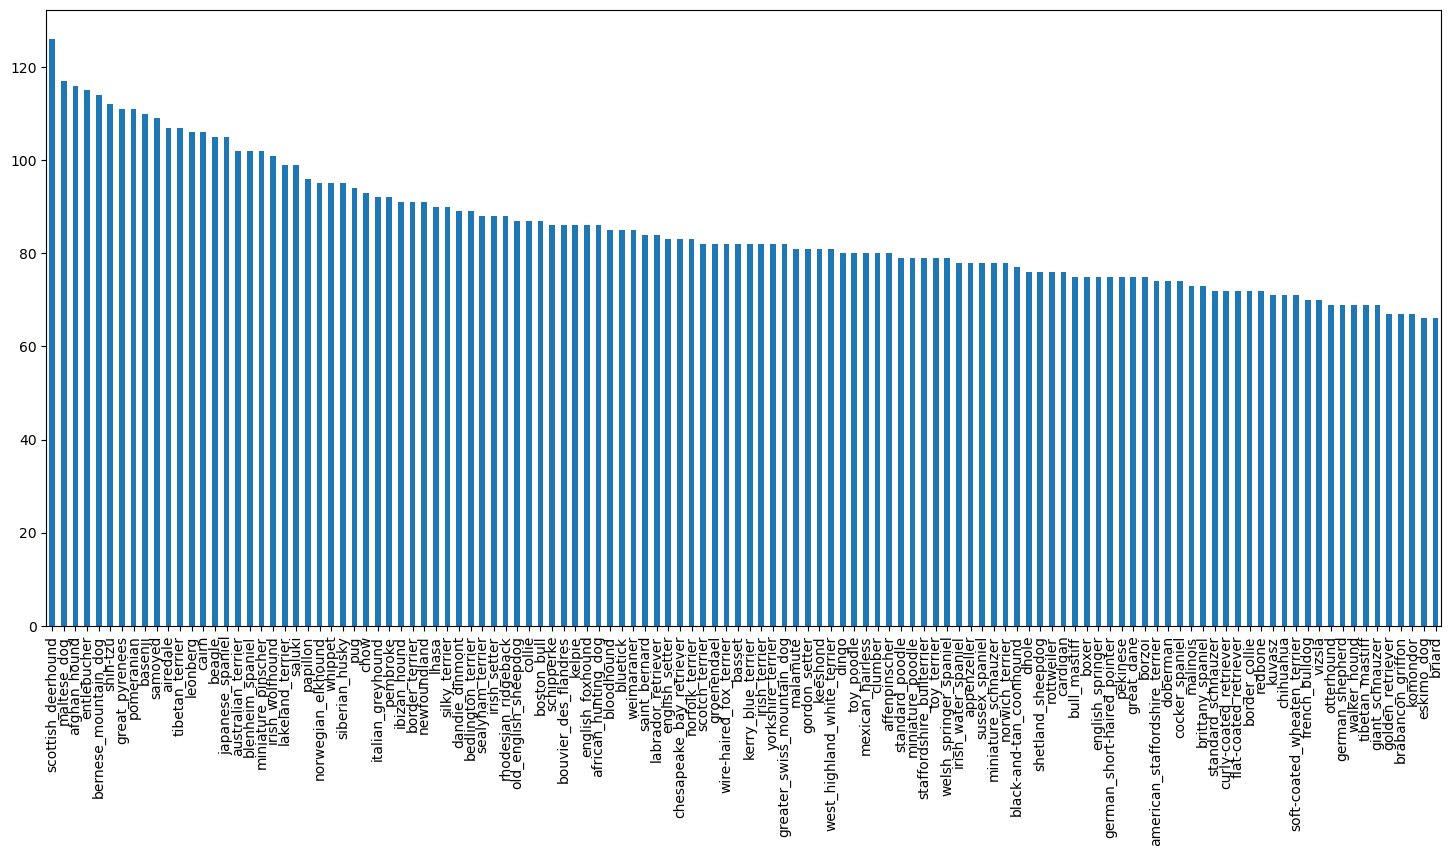

In [4]:
labels_csv["breed"].value_counts().plot.bar(figsize=(18,8))

In [5]:
import numpy as np
# average sample space for each breed
np.mean(labels_csv["breed"].value_counts())

85.18333333333334

In [6]:
np.median(labels_csv["breed"].value_counts())

82.0

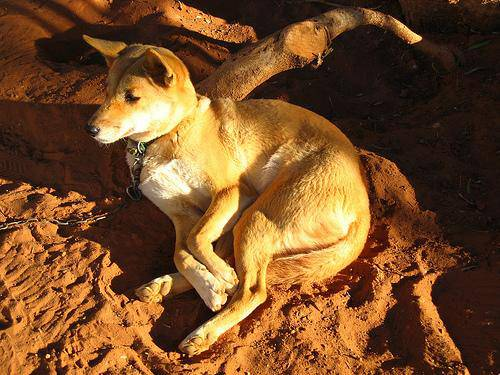

In [7]:
# viewing an image
from IPython.display import Image
Image("train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Making a list of all images with filenames

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
filenames= ["train/"+fname for fname in labels_csv["id"]+".jpg"]
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# checking whether all the file names and data is correctly imported
import os

if len(os.listdir("train/"))==len(filenames):
  print("Filenames match")
else:
  print("filenames mismatch")

Filenames match


In [11]:
len(filenames), len(labels_csv)

(10222, 10222)

In [12]:
len(os.listdir("train/"))

10222

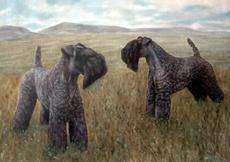

In [13]:
Image(filenames[10111])

In [14]:
labels_csv['breed'][10111]

'kerry_blue_terrier'

## Converting labels into numbers

In [15]:
labels= np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

### Checking if number of labels match the number of filenames

In [16]:
if len(labels)== len(filenames):
  print("Amount of labels matches the number of images")
else:
  print("Labels and images mismatch")

Amount of labels matches the number of images


In [17]:
# unique breeds
unique_breeds= np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

### Turing every label into a boolean array

In [18]:
boolean_labels= [label== unique_breeds for label in labels]
boolean_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
len(boolean_labels)

10222

In [20]:
labels[0]

'boston_bull'

### Turining boolean into integers

In [21]:
print(labels[0]) # original label
print(np.where(unique_breeds== labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # converts bool to int

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


This way we can access our arrays in numerical form

## Creating our own validation set

In [22]:
X= filenames
y= boolean_labels
X[:3], y[:3]

(['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'train/001cdf01b096e06d78e9e5112d419397.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False

Our goal is to minimize the time between experiment. Therefore we will work with a portion of dataset first and then apply it to all the data

In [23]:
# set the number of images to ~1000
NUM_IMAGES= 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [24]:
from sklearn.model_selection import train_test_split

# splitting in training and validation set

X_train, X_val, y_train, y_val= train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

## Preprocessing images

Steps:
1. Take image filepath as an input.
2. Use Tensorflow to read the file and save it to a variable `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our image (convert channels to (0,1) isntead of (0,255)
4. Resize the `image` to be of a common shape , (224,224)
5. Return the modified `image`

In [25]:
# convert an image to numpy array
from matplotlib.pyplot import imread
image= imread(filenames[1805])
image.shape

(500, 334, 3)

In [26]:
image[:2]

array([[[ 2,  0, 24],
        [28, 20, 44],
        [ 3,  0, 14],
        ...,
        [ 1,  0,  2],
        [15, 14, 19],
        [ 4,  5, 10]],

       [[ 1,  0, 19],
        [13,  5, 26],
        [11,  5, 17],
        ...,
        [10,  8, 11],
        [ 6,  5, 10],
        [ 0,  0,  5]]], dtype=uint8)

In [27]:
# turning image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 334, 3), dtype=uint8, numpy=
array([[[ 2,  0, 24],
        [28, 20, 44],
        [ 3,  0, 14],
        ...,
        [ 1,  0,  2],
        [15, 14, 19],
        [ 4,  5, 10]],

       [[ 1,  0, 19],
        [13,  5, 26],
        [11,  5, 17],
        ...,
        [10,  8, 11],
        [ 6,  5, 10],
        [ 0,  0,  5]]], dtype=uint8)>

In [28]:
IMG_SIZE=224

def process_image(image_path):
  """
  Takes an image path as input and convert it into tensor
  """
  # read in an image file
  image= tf.io.read_file(image_path)

  #turn the jpg into tensors with 3 color channels
  image= tf.image.decode_jpeg(image, channels=3)

  # normalize the color channels value
  image= tf.image.convert_image_dtype(image,tf.float32)

  # resize the image
  image= tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turning our data into batches

Turning to batches is important because all 10000+ images might not fit in memory

So thats why we do 32 (batch size) at a time

For tensorflow to process our image effectively, we need data in form of Tensor tuples:
`(image, label)`


In [30]:
# creating a function to return a tuple of (image, label)
def get_image_label(image_path, label):
  """
  Takes image path and label as parameter and return the image, label as a tuple
  """
  image= process_image(image_path)
  return image, label

In [31]:
get_image_label(X[42], tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [32]:
# function to turn all our data (X,y) into batches
BATCH_SIZE=32

def create_data_batches(x, y=None, valid_data=False, test_data=False):
  """
  Creates batches of data out of the image (X) and label (y) pairs.
  Shuffles the data if it's training data but not on validation data.
  Accepts test data with no labels
  """

  if test_data:
    print("Creating test data batches...")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only file paths
    data_batch= data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  else:
    data= tf.data.Dataset.from_tensor_slices((tf.constant(x), # file paths
                                             tf.constant(y))) # labels

    if not valid_data:
      print("Creating training data batches...")
      data= data.shuffle(buffer_size=len(x)) # shuffle data

    else:
      print("Creating validation data batches...")

    data= data.map(get_image_label)
    data_batch= data.batch(BATCH_SIZE)
    return data_batch

In [33]:
# creating test and validation batches
train_data= create_data_batches(X_train, y_train)
val_data= create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data is in batches, we can understand it better with a visualization

In [35]:
import matplotlib.pyplot as plt

def show_25_images(images, label):
  """
  Displays the plot of 25 images with their labels
  """

  plt.figure(figsize=(10,10))
  # loop through 25
  for i in range(25):
    ax= plt.subplot(5,5,i+1)
    # display the image
    plt.imshow(images[i])
    #  title as the label
    plt.title(unique_breeds[label[i].argmax()])
    # turning the axis off
    plt.axis("off")

In [36]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [93]:
# splitting data into images and labels
train_images, train_labels= next(train_data.as_numpy_iterator())
# train_images, train_labels

In [38]:
len(train_images), len(train_labels)

(32, 32)

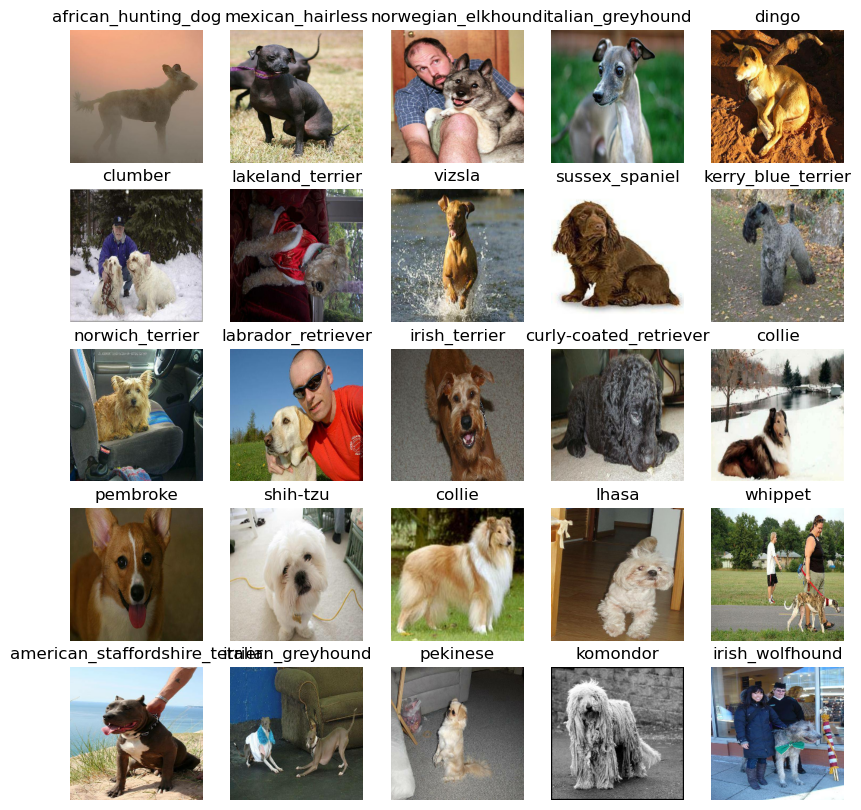

In [39]:
show_25_images(train_images, train_labels)

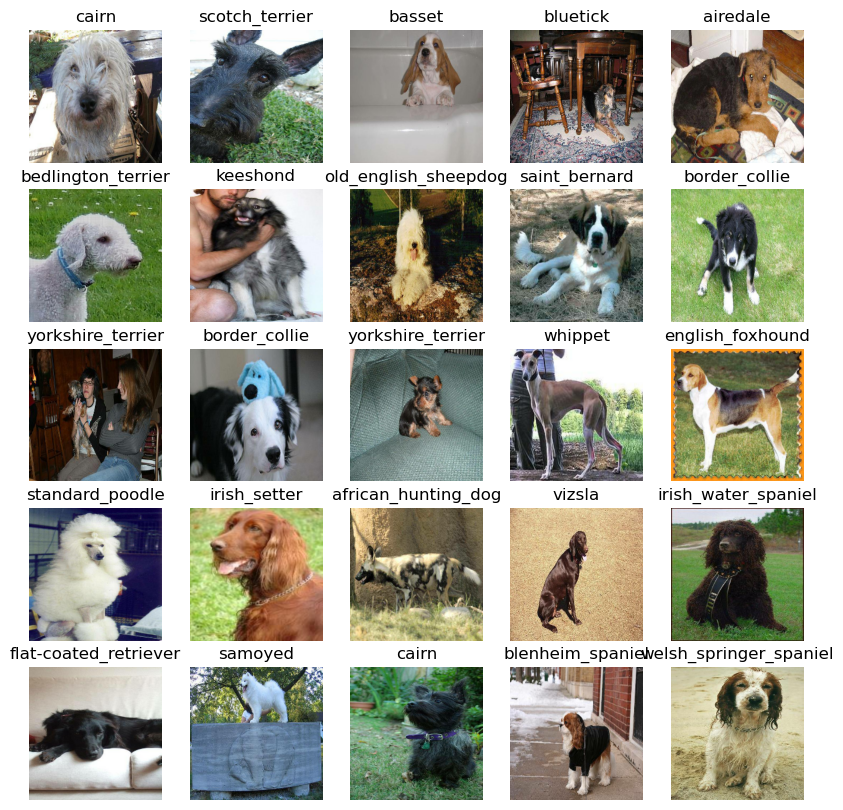

In [40]:
val_images, val_labels= next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are few things which we need to define:

* The input shape (our image shape, in form of tensors) to our model.
* The output shape(image labels, in form of tensors) of our model.
* Model url.

In [41]:
INPUT_SHAPE=[None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE=len(unique_breeds)
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we have our imput, output and model ready to go. So lets put them into keras deep learning model.

Knowing this, creating a function which:
* Takes input shape, output shape and model chosen as parameters.
* Defines the layers in a keras model in sequential fashion.
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells model the input shape it'll be getting)
* Returns the model

In [284]:
def create_model(input_shape= INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url= MODEL_URL):
  print("Building model with "+MODEL_URL)
  # sequential model

  model= tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # layer 1 (input)
      # tf.keras.layers.Dense(10),# hidden layer with 10 neurons
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")# layer 2 (output)
  ])

  model.compile(
      loss= tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  model.build(INPUT_SHAPE)

  return model

In [285]:
model= create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_6 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper function a model can use during training to do things like save progress, show progress or stop training early if no imporvement in noticed.

We will make 2 call backs, one for tensorboard to track our model's progress and another to stop model early so that it dont take too long to train

### Loading tensorboard

Steps:
1. Load the tensorboard extension
2. Create tensorboard callbacks which is able to save logs to a directory and pass it t our model's `fit()` function.
3. Visualize our model's training logs with `%tensorboard` magic function (after model training)

In [44]:
%load_ext tensorboard

In [279]:
import datetime

def create_tensorboard_callbacks():
  # create a directory for storing Tensorboard logs
  logdir= os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Prevents our model from overfitting when a certain evaluation metric stops improving

In [286]:
early_stopping =tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

## Train a model (on a subset of data)
Our first model will be trained only on 1000 images to make sure everything is working

In [287]:
NUM_EPOCHS= 100 #@param {type:"slider", min:10, max:100, step:10}

In [288]:
# checking if GPU is available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Creating a model function which:

* Creates model using `create_model()` function
* Setup a tensorboard callback using `create_tensorboard_callback()`
* Call the `fit()` method on our model to pass training and validation data with number of epochs (`NUM_EPOCHS`)
* Returns the model

In [289]:
def train_model():
  model= create_model()

  # callbacks
  tensorboard= create_tensorboard_callbacks()

  # fitting the model
  model.fit(x=train_data, # training data
            epochs= NUM_EPOCHS, #number of times training
            validation_data= val_data, #validation data
            validation_freq=1, # validating per epoch cycle
            callbacks=[tensorboard, early_stopping]) # callbacks

  return model

In [290]:
%%time

model= train_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 9s 176ms/step - loss: 4.5906 - accuracy: 0.0862 - val_loss: 3.3067 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 3s 134ms/step - loss: 1.6393 - accuracy: 0.7025 - val_loss: 2.1162 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 3s 134ms/step - loss: 0.5797 - accuracy: 0.9350 - val_loss: 1.6344 - val_accuracy: 0.5800
Epoch 4/100
25/25 [==============================] - 3s 132ms/step - loss: 0.2614 - accuracy: 0.9875 - val_loss: 1.4234 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 4s 174ms/step - loss: 0.1503 - accuracy: 0.9925 - val_loss: 1.3463 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 4s 172ms/step - loss: 0.1019 - accuracy: 1.0000 - val_loss: 1.3165 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================]

Our model is overfitting

### Checking the tensorboard logs

The tensorboard magic function `%tensorboard` will access the logs directory we created earlier and visualize its contents



In [51]:
%reload_ext tensorboard

In [291]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

## Making and evaluating predictions using trained models





In [292]:
predictions= model.predict(val_data, verbose=True)
predictions

7/7 [==============================] - 2s 135ms/step


array([[4.97320725e-04, 5.26971016e-05, 4.61325661e-04, ...,
        3.70090216e-04, 2.14303018e-05, 3.43647450e-02],
       [2.01838813e-03, 9.99788055e-04, 1.01469550e-02, ...,
        2.01051647e-04, 6.11201022e-03, 4.14453389e-04],
       [4.70143686e-06, 1.69263847e-04, 4.38416682e-05, ...,
        1.78144692e-05, 1.03201492e-05, 7.41106705e-05],
       ...,
       [9.79664219e-06, 5.75672175e-06, 8.91023083e-05, ...,
        3.96427959e-06, 2.17185770e-05, 1.02860264e-04],
       [7.40983803e-03, 7.12823647e-04, 2.49999721e-04, ...,
        1.61151867e-04, 9.23262778e-05, 1.46924527e-02],
       [3.45456036e-04, 4.97201727e-05, 8.23182694e-04, ...,
        4.20935499e-03, 2.93329329e-04, 7.61991105e-05]], dtype=float32)

In [293]:
predictions.shape

(200, 120)

In [294]:
len(X_val), len(unique_breeds)

(200, 120)

In [56]:
unique_breeds[predictions[0].argmax()]

'border_terrier'

### Sample prediction

In [63]:
# Image(filenames[1234])

In [64]:
# unique_breeds[boolean_labels[1234].argmax()]

In [65]:
# testx= create_data_batches(x=[filenames[1234]], test_data=True)
# testx

In [66]:
# pred2= model.predict(testx)

In [67]:
# pred2[0].argmax()

In [68]:
# unique_breeds[39]

Sum of predictions almost equals to 1

In [69]:
np.sum(predictions[0])

1.0

In [295]:
def prediction_index_validation(index):
  print(predictions[index])
  print(f"Max value (probability of prediction): {np.max(predictions[index])}")
  print(f"Sum of all probabilities: {np.sum(predictions[index])}")
  print(f"Max index: {np.argmax(predictions[index])}")
  print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

In [296]:
prediction_index_validation(1)

[2.01838813e-03 9.99788055e-04 1.01469550e-02 2.29149568e-03
 5.21481095e-04 2.92717341e-05 1.21830916e-02 4.01583267e-04
 3.30816983e-04 9.10846647e-05 3.70475405e-04 4.75237721e-05
 1.48307066e-04 3.67493449e-05 2.51192600e-04 4.99133719e-04
 4.60947538e-03 5.71789395e-04 1.55188306e-03 3.08880699e-04
 5.67220966e-04 5.87036120e-05 8.49421485e-04 1.52824156e-04
 2.56024941e-04 1.39159721e-03 2.47254781e-02 6.06709905e-03
 1.73327018e-04 1.09872490e-03 2.17268258e-04 6.11546740e-04
 8.21794791e-04 2.33488361e-04 5.95156853e-05 5.18000103e-04
 2.57869862e-04 2.85501522e-03 3.17917322e-04 4.25550388e-05
 5.02958545e-04 6.27470552e-04 2.53707985e-04 3.22944135e-04
 2.14023661e-04 8.64254683e-03 1.77102280e-03 9.28284659e-04
 5.80770597e-02 1.45702856e-04 1.16844538e-04 4.91708051e-04
 2.35000061e-05 1.24110564e-04 5.01563714e-04 2.11599050e-03
 2.82347086e-04 5.21330200e-02 3.47384921e-04 2.44848710e-03
 6.30775886e-03 3.64621201e-06 1.05704406e-04 1.01691294e-04
 1.43865617e-02 6.959767

Having the abov functionality with a scalining is better.

**Note:** prediction probability is also called confidence level

In [297]:
def get_pred_label(prediction_probablity):

  return unique_breeds[np.argmax(prediction_probablity)]

In [298]:
# get a predicted label based on an array of prediction probabilities

get_pred_label(predictions[80])

'pug'

In [299]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [300]:
images_=[]
labels_=[]

for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(unique_breeds[np.argmax(label)])


images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [301]:
labels_[100]

'bloodhound'

In [302]:
get_pred_label(predictions[100])

'bloodhound'

We can see that our model got this prediction correct

In [303]:
(labels_[81]), get_pred_label(predictions[81])

('irish_setter', 'dingo')

We got this prediction wrong

### Functionizing unbatchifying

In [304]:
def unbatchinfy(data):
  images_=[]
  labels_=[]

  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])


  return images_, labels_

In [305]:
images_, labels_= unbatchinfy(val_data)

In [306]:
images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we have:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Now let's visualize it with images

We will create a function which:
* Takes an array of probabilities, array of truth labels and array of images and an integer
* Convert the prediction probabilities to predicted labels
* Plot the predicted label, its predicted probability, truth label and target image on a single plot

In [307]:
def plot_pred(prediction_probablity, labels, images, n=1):
  """
  View the prediction, ground truth and label for sample n
  """

  pred_prob, true_label, image=prediction_probablity[n], labels_[n], images_[n]
  pred_label= get_pred_label(pred_prob)

  # showing green/red color on basic of the correctness of prediction
  if pred_label== true_label:
    final_color="green"
  else:
    final_color="red"

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(f"Predicted: {pred_label} {(np.max(pred_prob)*100)} Actual: {true_label}", color= final_color)

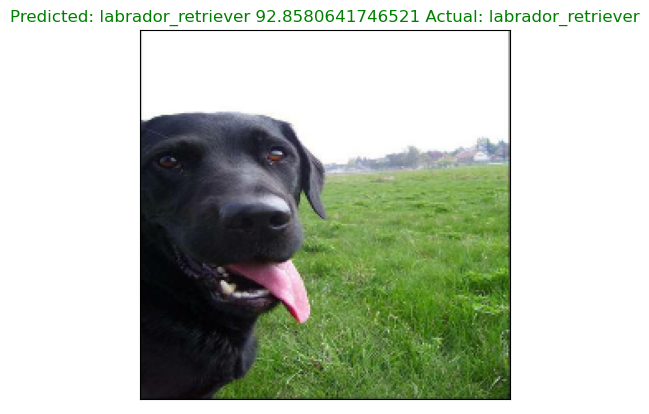

In [308]:
plot_pred(predictions, labels_, images_, 40)

Now we got a function to view our model's prediction, now lets make another to view top 10 predictions.

This function will:
* Take an input of prediction probabilities array and truth values array and an integer.
* Find the predicted label using `get_pred_label()`
* Fing the top 10:
  * Prediction probability indices
  * Prediction probability values
  * Prediction labels
  * Image of the dog breed

* Plot top 10 prediction probability values and labels, coloring the true value green

In [309]:
def plot_pred_top(prediction_probablity, labels,images, n=1, top=10):
  """
  Plots top 10 highest prediction confidences along with truth label
  top: changes the number of top values
  """
  pred_prob, true_label,image = prediction_probablity[n], labels[n], images[n]

  #get the pred label
  pred_label= get_pred_label(pred_prob)

  # top indices
  top_pred_index= pred_prob.argsort()[-top:][::-1] # takes last 'top' (ascending order) then reverses it to make it descending
  # top values
  top_pred_values= pred_prob[top_pred_index]
  # converting it into labels
  top_pred_labels= unique_breeds[top_pred_index]

  #plotting
  fig, ((ax2,ax1))= plt.subplots(nrows=1, ncols=2, figsize=(12,8))
  top_plot= ax1.bar(np.arange(len(top_pred_labels)), top_pred_values, color="grey")
  ax1.set_xticks(np.arange(len(top_pred_labels)), labels=top_pred_labels, rotation="vertical")

  # change color of true label
  if np.isin(true_label, top_pred_labels):
    top_plot[np.argmax(top_pred_labels== true_label)].set_color("green")
  else:
    pass

  # showing the image
  ax2.imshow(image)
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_title(true_label, color="green")

In [310]:
# labels_

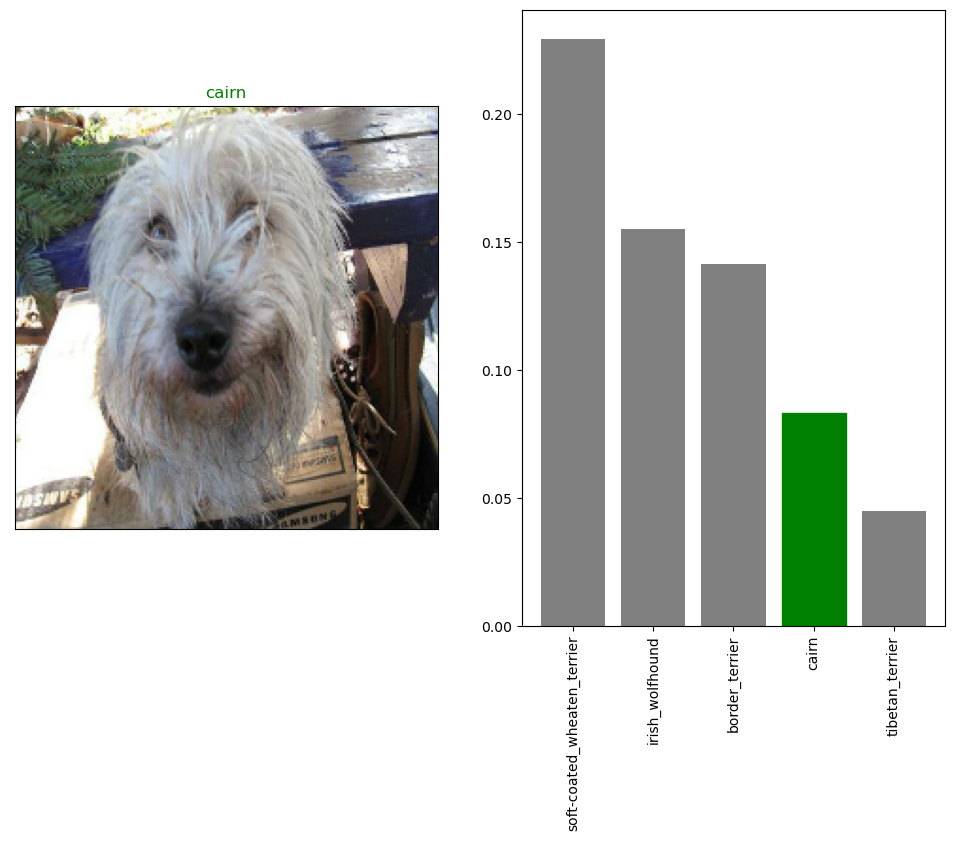

In [311]:
plot_pred_top(predictions, labels_, images_, n=0, top=5)

## Confusion Matrix

In [312]:
def get_pred_array(predictions):
  final_arr=[]
  for i in range(len(predictions)):
    final_arr.append(np.argmax(predictions[i]))

  return final_arr

In [313]:
labels_num=[]
for enteries in labels_ :
  for i in range(len(unique_breeds)):
    if enteries== unique_breeds[i]:
      labels_num.append(i)
      break
    else:
      #print(f"Couldn't parse {enteries} at {i}th index")

In [314]:
prediction_label_array= get_pred_array(predictions)

In [315]:
predictions[0].argmax()

103

In [316]:
len(labels_num)

200

In [220]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(labels_num, prediction_label_array)
mat

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

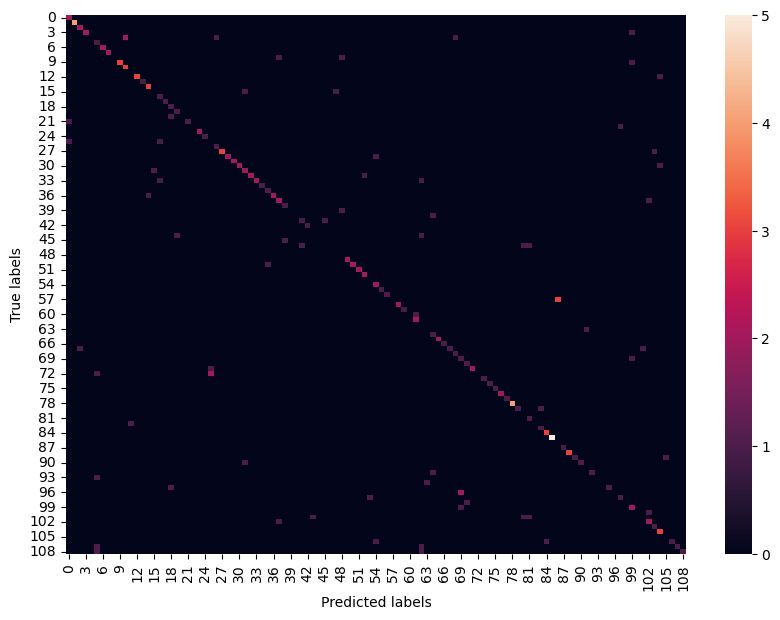

In [321]:
import seaborn as sns

fig, ax= plt.subplots(figsize=(10,7))
sns.heatmap(mat);
plt.xlabel("Predicted labels");
plt.ylabel("True labels");


## Saving and reloading a trained model

In [322]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [323]:
def load_model(model_path):
  """
  Loads a model from the specified path
  """

  print(f"Loading model from: {model_path}")
  model= tf.keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer": hub.KerasLayer}) # because we are using a predefined model

  return model

In [324]:
#save a model
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: models\20230620-091452-1000-images-mobilenetv2-Adam.h5...


'models\\20230620-091452-1000-images-mobilenetv2-Adam.h5'

In [325]:
 # load a trained model
 loaded_1000_img= load_model("models\\20230620-091452-1000-images-mobilenetv2-Adam.h5")

Loading model from: models\20230620-091452-1000-images-mobilenetv2-Adam.h5


In [326]:
# evaluating the model
model.evaluate(val_data)

7/7 [==============================] - 1s 86ms/step - loss: 1.2224 - accuracy: 0.6650


[1.2224454879760742, 0.6650000214576721]

In [327]:
loaded_1000_img.evaluate(val_data)

7/7 [==============================] - 1s 86ms/step - loss: 1.2224 - accuracy: 0.6650


[1.2224454879760742, 0.6650000214576721]

## Training the model on full dataset


In [328]:
len(X), len(y)

(10222, 10222)

### Creating data batches of full data

In [329]:
full_data= create_data_batches(X,y)

Creating training data batches...


In [330]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

### Creating model for full data

In [331]:
full_model= create_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


### Creating callbacks

In [332]:
# tensorboard callback
full_model_tensorboard= create_tensorboard_callbacks()
# No validation set so we cant track val_accuracy, therefore we track accuracy
full_model_early_stopping= tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

### Fitting the model

In [333]:
%%time

full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 57s 157ms/step - loss: 1.3358 - accuracy: 0.6711
Epoch 2/100
320/320 [==============================] - 33s 103ms/step - loss: 0.3957 - accuracy: 0.8862
Epoch 3/100
320/320 [==============================] - 33s 104ms/step - loss: 0.2355 - accuracy: 0.9379
Epoch 4/100
320/320 [==============================] - 35s 108ms/step - loss: 0.1544 - accuracy: 0.9630
Epoch 5/100
320/320 [==============================] - 36s 111ms/step - loss: 0.1059 - accuracy: 0.9797
Epoch 6/100
320/320 [==============================] - 35s 110ms/step - loss: 0.0780 - accuracy: 0.9850
Epoch 7/100
320/320 [==============================] - 36s 111ms/step - loss: 0.0583 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 36s 111ms/step - loss: 0.0452 - accuracy: 0.9952
Epoch 9/100
320/320 [==============================] - 36s 111ms/step - loss: 0.0366 - accuracy: 0.9968
Epoch 10/100
320/320 [==============================] - 36s 112m

In [334]:
save_model(full_model, "full-image-set-mobilenetv2-Adam")

Saving model to: models\20230620-095037-full-image-set-mobilenetv2-Adam.h5...


'models\\20230620-095037-full-image-set-mobilenetv2-Adam.h5'

In [335]:
loaded_full_model=load_model("models\\20230620-095037-full-image-set-mobilenetv2-Adam.h5")

Loading model from: models\20230620-095037-full-image-set-mobilenetv2-Adam.h5


## Making predictions on test data

Since our model has been trained on images in the form of tensor batches, we need to convert our test images into that format as well.

Luckily, we have made a function `create_data_batches()` which converts our filenames to data batches and returns it.

To make predictions on the test data, we need to:
* Get the test image filenames
* Convert the filenames into data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since test data has no labels)
* Make a predictions array by passing the test batches into `predict()` method from our model

In [338]:
test_path="test/"
test_filenames= [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['test/000621fb3cbb32d8935728e48679680e.jpg',
 'test/00102ee9d8eb90812350685311fe5890.jpg',
 'test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'test/002f80396f1e3db687c5932d7978b196.jpg',
 'test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [339]:
len(test_filenames)

10357

In [340]:
test_data= create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [341]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

### Passing test data to full model for prediction

It will take fairly long time

In [342]:
%%time
test_predictions= loaded_full_model.predict(test_data, verbose=True)

324/324 [==============================] - 36s 104ms/step
CPU times: total: 1min 36s
Wall time: 37.1 s


In [343]:
np.savetxt("predictions/preds_array.csv", test_predictions, delimiter=',')

In [345]:
test_predictions[:2]

array([[4.57960796e-12, 2.95388415e-13, 2.37875280e-16, 1.22531464e-14,
        8.17550983e-14, 7.56637971e-13, 3.17359009e-18, 1.00695026e-13,
        3.61145457e-15, 1.40371731e-12, 2.13604599e-15, 3.46077957e-13,
        3.52430013e-14, 8.78297879e-10, 2.84823405e-15, 3.66776379e-13,
        1.27536025e-15, 4.36797738e-15, 4.67866934e-12, 5.80225212e-13,
        2.25657052e-15, 5.18744336e-13, 1.99964773e-13, 4.35220987e-15,
        1.30859624e-15, 3.97733964e-11, 1.44646360e-14, 3.84697921e-18,
        6.25824073e-17, 1.02576389e-12, 9.78887314e-14, 5.63977000e-14,
        1.03546169e-14, 4.68895478e-11, 4.64925731e-17, 5.93171589e-18,
        4.16620866e-13, 4.32612252e-15, 6.62475988e-14, 1.82997129e-09,
        1.41642435e-13, 2.60575223e-15, 3.39974441e-13, 3.90813061e-16,
        5.18184616e-13, 1.96387368e-11, 8.53792541e-14, 2.97105602e-13,
        1.32857863e-13, 2.44987461e-13, 9.76108825e-15, 1.22633056e-12,
        1.65487003e-12, 5.00720139e-16, 8.86825539e-14, 5.914143

In [346]:
test_predictions.shape

(10357, 120)

## Preparing test dataset for kaggle

sample submission format: https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To accomplish this, we will:
* Create pandas dataframe with an ID column as well as a column for each dog breed.
* Fill ID by filepathname
* Add data to each column name from prediction probabilities
* Export dataframe as a csv

In [347]:
preds_df= pd.DataFrame(columns=["id"]+ list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


### Extracting ID's from pathname

In [349]:
test_ids= [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:10]

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442']

In [350]:
preds_df["id"]= test_ids
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [351]:
preds_df[list(unique_breeds)]= test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,4.579608e-12,2.953884e-13,2.378753e-16,1.225315e-14,8.175510e-14,7.566380e-13,3.173590e-18,1.006950e-13,3.611455e-15,...,4.234601e-14,1.291172e-15,1.621278e-15,6.728239e-17,8.251512e-16,5.735406e-14,3.144530e-14,4.909700e-15,1.355170e-10,4.490028e-12
1,00102ee9d8eb90812350685311fe5890,4.924602e-07,9.728083e-08,7.794365e-10,1.385575e-11,3.468548e-08,7.017349e-11,8.004087e-08,2.684446e-08,1.408442e-10,...,1.266869e-10,2.387250e-08,4.901255e-11,1.180783e-07,2.242690e-09,9.029557e-10,3.852194e-05,2.938960e-13,1.121171e-09,4.794221e-12
2,0012a730dfa437f5f3613fb75efcd4ce,5.440182e-14,3.807590e-08,2.533460e-10,2.005256e-13,1.863211e-12,1.292009e-09,1.564098e-13,1.535113e-13,2.877478e-11,...,1.330662e-13,4.515158e-13,2.541001e-09,6.519565e-08,7.628001e-09,6.138654e-09,3.308151e-14,3.960574e-08,4.694020e-13,4.524814e-13
3,001510bc8570bbeee98c8d80c8a95ec1,1.697258e-07,1.228805e-08,1.546296e-08,8.608396e-07,1.321140e-06,2.713419e-07,5.837292e-13,9.121755e-11,3.102358e-09,...,1.124342e-07,2.615077e-11,2.472516e-06,1.516305e-11,6.467846e-08,5.436477e-12,9.780295e-19,1.110025e-02,2.554707e-12,7.327824e-09
4,001a5f3114548acdefa3d4da05474c2e,2.048122e-05,1.396195e-06,5.188557e-10,2.154598e-11,3.969707e-11,9.623998e-13,1.097761e-11,1.868410e-10,6.809286e-10,...,2.172072e-08,6.910206e-12,5.599867e-12,1.244785e-12,3.453245e-11,1.785700e-11,4.867642e-13,1.075805e-08,3.583124e-11,2.048751e-09


In [352]:
preds_df.isna().sum()

id                             0
affenpinscher                  0
afghan_hound                   0
african_hunting_dog            0
airedale                       0
                              ..
welsh_springer_spaniel         0
west_highland_white_terrier    0
whippet                        0
wire-haired_fox_terrier        0
yorkshire_terrier              0
Length: 121, dtype: int64

### Saving our predictions to csv format

In [353]:
preds_df.to_csv("predictions/full_model_predictions_submission_1_mobilenetv2.csv", index=False)

## Making predictions on custom images

Requirement:

* Filepaths
* Create images into data batches
* Predict the class
* Convert the output into labels

In [372]:
custom_path="custom-photos/"

In [373]:
custom_image_paths= [custom_path+ fname for fname in os.listdir(custom_path)]

In [374]:
custom_image_paths

['custom-photos/1.jfif', 'custom-photos/2.jfif']

Turn custom images into batches

In [375]:
custom_data=create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

### Make predictions on custom data

In [377]:
custom_preds= loaded_full_model.predict(custom_data)
# custom_preds

1/1 [==============================] - 0s 57ms/step


In [378]:
custom_labels_num=[ get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_labels_num

['siberian_husky', 'english_setter']

In [379]:
custom_image=[]

for image in custom_data.unbatch().as_numpy_iterator():
  custom_image.append(image)

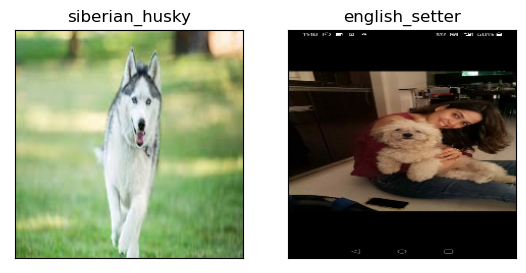

In [380]:
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_image):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_labels_num[i])
  plt.imshow(image)